### Housekeeping

In [1]:
import os
import pandas as pd
import random
import numpy as np
import librosa
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import datetime as datetime
import itertools
from collections import defaultdict
import random
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, precision_score, average_precision_score

import ibm_boto3
from ibm_botocore.client import Config, ClientError

import tensorflow as tf
from tensorflow.keras import layers, models, Input, optimizers, metrics, regularizers
from tensorflow.keras import backend as K

SEED = 101
random.seed(SEED)

print(tf.__version__)

2.1.0


### Loading files from bucket

In [27]:
DATA_PATH = '/home/csancini/w251-data/'
BUCKET_NAME = 'cv-audio'
DEV_FILE = 'dev.tsv'
AUDIO_FILE = 'dev-clips.tgz'
MFCC_PICKLE = 'mfcc.bin'
CLIPS_PATH = DATA_PATH + 'dev-clips/'
TEST_CLIPS = DATA_PATH + 'test-clips/'

In [ ]:
# Constants for IBM S3 values
COS_ENDPOINT = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'
COS_API_KEY_ID = 'LKRr_5OhOyBgvHG6WH2wm9F_2bHC2sn1vV4eaCYdgpsm'
COS_AUTH_ENDPOINT = 'https://iam.cloud.ibm.com/identity/token'
COS_RESOURCE_CRN = 'crn:v1:bluemix:public:cloud-object-storage:global:a/ea337a3eba2f43c6b813f319db505255:0f9730a8-f2b8-42ce-b276-f9e13877a5f0::'

# Create resource
cos = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint=COS_AUTH_ENDPOINT,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

In [ ]:
bucket = cos.Bucket(BUCKET_NAME)
obj = bucket.Object(DEV_FILE)

with open(DATA_PATH + DEV_FILE, 'wb') as data:
    obj.download_fileobj(data)

In [ ]:
bucket = cos.Bucket(BUCKET_NAME)
obj = bucket.Object(AUDIO_FILE)

with open(DATA_PATH + AUDIO_FILE, 'wb') as data:
    obj.download_fileobj(data)

### EDA

In [ ]:
df = pd.read_csv(DATA_PATH + DEV_FILE, sep='\t')

In [ ]:
df.head()

In [ ]:
len(df)

In [ ]:
# check for unique voices 
df.nunique()

In [ ]:
# check for voices up_votes only
len(df[df.down_votes == 0]) / len(df)

In [ ]:
df[df.down_votes == 0].nunique()

In [ ]:
df.up_votes.unique().tolist()

In [ ]:
df.down_votes.unique().tolist()

In [ ]:
(df.up_votes < df.down_votes).sum()

In [ ]:
df.gender.value_counts()

In [ ]:
df.accent.value_counts()

### Pairing Data

In [ ]:
voices_by_path = {}
voices_by_id = defaultdict(lambda: list())
for x in df[['client_id', 'path']].values.tolist():
    voices_by_path.update({x[1]: x[0]})
    voices_by_id[x[0]].append(x[1])

In [ ]:
next(iter(voices_by_path.items()))

In [ ]:
next(iter(voices_by_id.items()))

In [ ]:
positive_pairs = []
sample_voices = []
for voices in voices_by_id.values():
    
    # saves one recording of each person to create negative pairs later
    sample_voices.append(voices[0])
    
    if(len(voices) < 2): continue
    # create all combinations of voices of the same person
    for left, right in itertools.combinations(voices, 2):
        positive_pairs.append([left, right, 1])    

In [ ]:
len(positive_pairs), len(sample_voices)

In [ ]:
positive_pairs[0:2]

In [ ]:
voices_by_id[voices_by_path['common_voice_en_20002398.mp3']]

In [ ]:
negative_pairs = []
for left, right in itertools.combinations(sample_voices, 2):
    negative_pairs.append([left, right, 0])

In [ ]:
len(negative_pairs)

In [ ]:
# sample a few negative pairs as there too many of them
negative_pairs = random.sample(negative_pairs, len(positive_pairs)*2)

In [ ]:
len(negative_pairs)

In [ ]:
all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)
all_pairs[0:10]

### Loading MP3 files

In [37]:
def get_clip(file_name, max_pad_len=400):
    wave, sr = librosa.load(file_name, mono=True)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=sr) 

    pad_width = max_pad_len - mfcc.shape[1]
    
    if (pad_width < 0): 
        pad_width = 0
        mfcc = mfcc[:, 0:max_pad_len]
    
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc.astype(np.float32)

In [ ]:
all_filenames = df['path'].values.tolist()

In [ ]:
len(all_filenames)

In [ ]:
clips = {}
for i in tqdm(range(len(all_filenames))):  
    path = CLIPS_PATH + all_filenames[i]
    clips.update({all_filenames[i]: get_clip(path)})

In [ ]:
with open(DATA_PATH + MFCC_PICKLE, 'wb') as f:
    pickle.dump((clips, all_pairs) , f)

In [ ]:
for i in clips.items():
    print(i[0])
    print(i[1])
    print(i[1].shape)
    break

### Creating the Dataset

In [3]:
with open(DATA_PATH + MFCC_PICKLE, 'rb') as f:
    clips, all_pairs = pickle.load(f)

In [4]:
def get_dataset():
    left = []
    right = []
    labels = []  
    
    for pair in all_pairs:       
        left.append([clips.get(pair[0])])
        right.append([clips.get(pair[1])])
        labels.append(pair[2])        
    
    left = np.array(left)
    right = np.array(right)
    labels = np.array(labels)

    left = np.rollaxis(np.rollaxis(left, 3, 1), 3, 1)
    right = np.rollaxis(np.rollaxis(right, 3, 1), 3, 1)

    dataset_size = len(all_pairs)
    train_size = int(dataset_size*0.7)    
   
    return left[0:train_size], \
           left[train_size:dataset_size], \
           right[0:train_size], \
           right[train_size:dataset_size], \
           labels[0:train_size], \
           labels[train_size:dataset_size]

In [5]:
left_train, left_val, right_train, right_val, labels_train, labels_val = get_dataset()

In [6]:
print(left_train.shape, right_train.shape)

(48892, 20, 400, 1) (48892, 20, 400, 1)


In [7]:
print(left_val.shape, right_val.shape)

(20954, 20, 400, 1) (20954, 20, 400, 1)


In [8]:
print(labels_train.shape, labels_val.shape)

(48892,) (20954,)


In [9]:
del(clips)

### Create Model

In [10]:
def get_siamese_model():
  
    # Define the tensors for the two input images
    left_input = Input((20, 400, 1))
    right_input = Input((20, 400, 1))
    
    # Convolutional Neural Network
    model = models.Sequential()    
    model.add(layers.Conv2D(
        32, 
        (10,10), 
        padding = 'same',
        activation='relu', 
        input_shape=(20, 400, 1), 
        kernel_regularizer=regularizers.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(
        64, 
        (7,7),  
        padding = 'same',
        activation='relu',
        kernel_regularizer=regularizers.l2(2e-4)))    
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(
        64, 
        (4,4), 
        padding = 'same', 
        activation='relu', 
        kernel_regularizer=regularizers.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(
        128, 
        (4,4),  
        padding = 'same',
        activation='relu', 
        kernel_regularizer=regularizers.l2(2e-4)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(
        1024, 
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(1e-3)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = layers.Dense(1, activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = models.Model(inputs=[left_input, right_input],outputs=prediction)
    
    # return the model
    return siamese_net

### Training

In [11]:
model = get_siamese_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 400, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20, 400, 1)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         13408672    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024)         0           sequential[1][0]             

In [12]:
LR = 1e-4
model.compile(loss="binary_crossentropy", optimizer = optimizers.Adam(lr = LR))

In [13]:
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

log_dir = DATA_PATH + 'logs/EN-' + now
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = DATA_PATH + 'checkpoints/EN-' + now
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True)

In [14]:
print(checkpoint_path)
print(log_dir)

/home/csancini/w251-data/checkpoints/EN-20200329-133052
/home/csancini/w251-data/logs/EN-20200329-133052


In [15]:
BATCH = 512
EPOCHS = 200

history = model.fit(
   [left_train, right_train], 
    labels_train, 
    batch_size = BATCH, 
    epochs = EPOCHS,
    validation_data = ([left_val, right_val], labels_val),
    callbacks=[checkpoints_callback, tensorboard_callback])

Train on 48892 samples, validate on 20954 samples
Epoch 1/200
48640/48892 [============================>.] - ETA: 0s - loss: 1.6168WARNING:tensorflow:From /usr/local/lib/python3.5/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/csancini/w251-data/checkpoints/EN-20200329-133052/assets
48892/48892 [==============================] - 38s 777us/sample - loss: 1.6138 - val_loss: 0.9905
Epoch 2/200
48892/48892 [==============================] - 34s 688us/sample - loss: 0.7620 - val_loss: 0.6187
Epoch 3/200
48892/48892 [==============================] - 34s 686us/sample - loss: 0.5260 - val_loss: 0.4749
Epoch 4/200
48892/48892 [==============================] - 34s 696us/sample - loss: 0.4214 

In [16]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


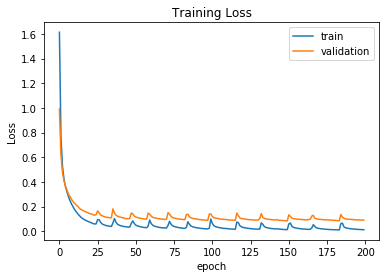

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Inference

In [18]:
def get_accuracy(labels, predicted_scores, threshold=0.5):
    predicted = predicted_scores > threshold
    predicted = predicted.astype(int).ravel()
    return np.round(100*accuracy_score(labels, predicted), 2)

In [20]:
def plot_roc_auc(actual, predictions):
    fpr, tpr, roc_thresholds = roc_curve(actual, predictions)
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC  = {:.3f}'.format(auc_value))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [21]:
def plot_precision_recall(actual, predictions):
    precision, recall, pr_thresholds = precision_recall_curve(actual, predictions)
    avg_precision = average_precision_score(actual, predictions)
    plt.plot(recall, precision, label='Avg Precision  = {:.3f}'.format(avg_precision))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')
    plt.show()

In [ ]:
#saved_model = get_siamese_model()
#saved_model.load_weights(checkpoint_path + '/variables/variables')

#### Validation Set

In [22]:
predicted_val = model.predict([left_val, right_val]).ravel()

In [23]:
#accuracy is a misleading metric here, we should look for the precision-recall
#plot and select a threshold that priviledges precision but do not causes a 
#too low recall
print('accuracy:', get_accuracy(labels_val, predicted_val))

accuracy: 97.54


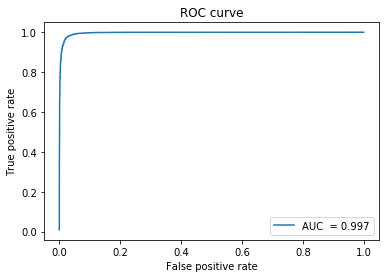

In [24]:
plot_roc_auc(labels_val, predicted_val)

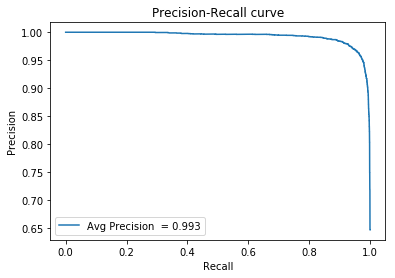

In [25]:
plot_precision_recall(labels_val, predicted_val)

#### Test Set

In [29]:
test_filenames = os.listdir(TEST_CLIPS)
test_filenames

['Xander_English_2.mp3',
 'Rose_Portuguese_3.m4a',
 'Other_Spanish_4.mp3',
 'Xander_English_5.m4a',
 'Xander_English_3.mp3',
 'Other_Spanish_5.mp3',
 'Xander_English_4.mp3',
 'Carlos_English_1.m4a',
 'Rose_Portuguese_1.m4a',
 'Other_Spanish_2.mp3',
 'Carlos_English_2.m4a',
 'Xander_English_1.mp3',
 'Other_Spanish_3.mp3',
 'Carlos_Portuguese_2.m4a',
 'Rose_Portuguese_2.m4a',
 'Rose_Portuguese_4.m4a',
 'Carlos_Portuguese_1.m4a',
 'Carlos_Portuguese_3.m4a',
 'Xander_English_6.m4a',
 'Other_Spanish_1.mp3',
 'Carlos_English_3.m4a',
 'Rose_Portuguese_5.m4a']

In [32]:
test_pairs = []
for a, b in itertools.combinations(test_filenames, 2):
    test_pairs.append([a, b, int(a[0:a.find('_')] == b[0:b.find('_')])])
test_pairs[0]

['Xander_English_2.mp3', 'Rose_Portuguese_3.m4a', 0]

In [35]:
def get_test_dataset():
    left = []
    right = []
    labels = [] 

    test_clips = {}
    for r in os.listdir(TEST_CLIPS):  
        test_path = TEST_CLIPS + r
        test_clips.update({r: get_clip(test_path)})
    
    for pair in test_pairs:       
        left.append([test_clips.get(pair[0])]) 
        right.append([test_clips.get(pair[1])])
        labels.append(pair[2])        
    
    left = np.array(left).astype(np.float32)
    right = np.array(right).astype(np.float32)
    labels = np.array(labels).astype(int)

    left = np.rollaxis(np.rollaxis(left, 3, 1), 3, 1)
    right = np.rollaxis(np.rollaxis(right, 3, 1), 3, 1)

    return left, right, labels

In [38]:
test_left, test_right, labels_test = get_test_dataset()
test_left.shape, test_right.shape, labels_test.shape

((231, 20, 400, 1), (231, 20, 400, 1), (231,))

In [41]:
predicted_test = model.predict([test_left, test_right]).ravel()

In [42]:
print('accuracy:', get_accuracy(labels_test, predicted_test))

accuracy: 87.45


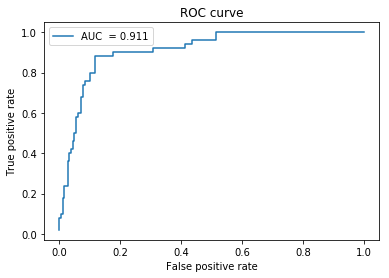

In [44]:
plot_roc_auc(labels_test, predicted_test)

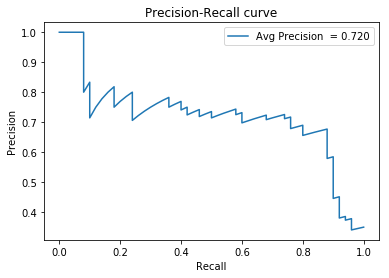

In [45]:
plot_precision_recall(labels_test, predicted_test)

In [46]:
test_df = pd.DataFrame(test_pairs, columns=['voice_a', 'voice_b', 'label'])
test_df['scores'] = predicted_test
test_df.head()

,voice_a,voice_b,label,scores
0,Xander_English_2.mp3,Rose_Portuguese_3.m4a,0,0.000087
1,Xander_English_2.mp3,Other_Spanish_4.mp3,0,0.057352
2,Xander_English_2.mp3,Xander_English_5.m4a,1,0.745713
3,Xander_English_2.mp3,Xander_English_3.mp3,1,0.569276
4,Xander_English_2.mp3,Other_Spanish_5.mp3,0,0.000053


In [48]:
false_positives = (test_df['scores'] > 0.5) & (test_df['label'] == 0)
test_df[false_positives]

,voice_a,voice_b,label,scores
21,Rose_Portuguese_3.m4a,Other_Spanish_4.mp3,0,0.969830
24,Rose_Portuguese_3.m4a,Other_Spanish_5.mp3,0,0.535046
31,Rose_Portuguese_3.m4a,Other_Spanish_3.mp3,0,0.582624
41,Other_Spanish_4.mp3,Xander_English_5.m4a,0,0.681694
46,Other_Spanish_4.mp3,Rose_Portuguese_1.m4a,0,0.785764
52,Other_Spanish_4.mp3,Rose_Portuguese_2.m4a,0,0.998242
53,Other_Spanish_4.mp3,Rose_Portuguese_4.m4a,0,0.999282
59,Other_Spanish_4.mp3,Rose_Portuguese_5.m4a,0,0.999613
111,Xander_English_4.mp3,Carlos_English_1.m4a,0,0.549276
114,Xander_English_4.mp3,Carlos_English_2.m4a,0,0.761858


In [49]:
false_negatives = (test_df['scores'] < 0.5) & (test_df['label'] == 1)
test_df[false_negatives]

,voice_a,voice_b,label,scores
17,Xander_English_2.mp3,Xander_English_6.m4a,1,0.433957
57,Other_Spanish_4.mp3,Other_Spanish_1.mp3,1,0.468587
67,Xander_English_5.m4a,Xander_English_1.mp3,1,0.203956
98,Other_Spanish_5.mp3,Other_Spanish_2.mp3,1,0.212309
134,Carlos_English_1.m4a,Carlos_Portuguese_1.m4a,1,0.000259
138,Carlos_English_1.m4a,Carlos_English_3.m4a,1,0.008921
145,Rose_Portuguese_1.m4a,Rose_Portuguese_2.m4a,1,0.234085
198,Carlos_Portuguese_2.m4a,Carlos_Portuguese_3.m4a,1,0.000964
201,Carlos_Portuguese_2.m4a,Carlos_English_3.m4a,1,0.221964
215,Rose_Portuguese_4.m4a,Rose_Portuguese_5.m4a,1,0.059510


### Production

In [ ]:
PROD_PATH = DATA_PATH + 'production/'
REF_CLIP = PROD_PATH + 'ref_clip.wav'
REF_CLIPS_PICKLE = PROD_PATH + 'ref_clips.pickle'
BEST_MODEL_PATH = DATA_PATH + 'production/model/'
SCORE_THRESHOLD = 0.5
REF_CLIPS = None
MODEL = None

In [123]:
def get_clips(clip_path, recorded_byte_array, min_size=1):    
    """
    Splits a long clip in multiple smaller clips with MFCC length of 400. 
    Also discards the final part of the audio file the is not a multiple of 400.
    """
    
    #TODO: this function should also work with a recorded byte array
    # since we don't need to save the user's voice everytime they try to open the door
    
    pad_length = 400
    
    wave, sr = librosa.load(clip_path, mono=True)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=sr)
        
    n_clips = int(mfcc.shape[1] / pad_length)
    
    if (n_clips < min_size):
        raise Exception('Audio file too short. Expected MFCC equal or greater than {}, but was: {}'.format(
            min_size*400, mfcc.shape[1]))
    
    # cut the recording in smaller clips
    ref_clips = []
    for i in range(1, n_clips+1):
        ref_clips.append(mfcc[:, (i-1)*pad_length:i*pad_length])
        
    # REMOVED: a tiny part could lead to a bad score
    # add the last clip and fill with zeros up to 400
    #last = mfcc[:, n_clips*pad_length:mfcc.shape[1]]
    #if(last.shape[1] > 0): 
    #    ref_clips.append(np.pad(
    #        last, 
    #        pad_width = ((0, 0), (0, pad_length - last.shape[1])),
    #        mode = 'constant'))
    
    return ref_clips
    

In [ ]:
def setup_voice_system():   
    """
    Records the voice of the user, splits the voice in small clippings and saves
    the clippings for later inference.
    """
    
    #TODO
    #record the voice and save the file in path REF_CLIP
    #if time allows, multiple users to open the door
    
    # expect at least 3 clips from reference recording 
    ref_clips = get_clips(REF_CLIP, 3)
    
    with open(REF_CLIPS_PICKLE, 'wb') as handle: 
        pickle.dump(ref_clips, handle)   

In [ ]:
def start_voice_system():
    """
    Loads the reference clippings and the weights of the model.
    """
    
    try:
        with open(REF_CLIPS_PICKLE, 'rb') as handle:
            ref_clips = pickle.load(handle) 
    except Exception as e:
        raise Exception('Could not find reference voice clips. Was the system set up?')

        
    model = models.load_model(BEST_MODEL_PATH)    
        
    try:
        with open(REF_CLIPS_PICKLE, 'rb') as handle:
            ref_clips = pickle.load(handle) 
    except Exception as e:
        raise Exception('Could not find reference voice clips. Was the system set up?')
        
    return ref_clips, model
    

In [ ]:
def get_user_voice():
    """
    Record the user voice anr return smaller processed MFCC clippings
    """
    # TODO
    recorded_byte_array = np.array()
    
    return get_clips(None, recorded_byte_array, min_size=1):   
    

In [131]:
def get_inference_dataset(ref_clips, actual_clips):
    left = []
    right = []
    
    for ref in reference_clips:
        for actual in actual_clips:
            left.append([ref]) 
            right.append([actual]) 
    
    left = np.array(left).astype(np.float32)
    right = np.array(right).astype(np.float32)

    left = np.rollaxis(np.rollaxis(left, 3, 1), 3, 1)
    right = np.rollaxis(np.rollaxis(right, 3, 1), 3, 1)

    return left, right

In [128]:
def speech_unlock(left, right):
    return np.mean(model.predict([left, right])) > SCORE_THRESHOLD

In [ ]:
# main.py in TX2 should contain something like this

setup_voice_system()

REF_CLIPS, MODEL = start_voice_system()

actual_clips = get_user_voice()

left, right = get_inference_dataset(ref_clips, actual_clips)

unlock = speech_unlock(left, right)

if (unlock):
    #do something